In [24]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
import scipy

import sys
sys.path.append("../../..")

import torch

from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from ml.regression.drn.modules import DRNDataset, ratioTransform
from ml.regression.drn.dataset_making import LayerClustersTensorMaker

In [2]:
def g(beamEnergy_s, tracksterEnergy) -> float:
    """ Correction function of trackster energy 
    Returns corrected trackster energy
    """
    a = [-0.27294974, -0.25671231,  1.01280186]
    return tracksterEnergy * 1/ (a[0] * beamEnergy_s**(a[1]) + a[2] )

In [3]:
def h(gunEnergy, ratioToCorrect) -> float:
    """ Corrects dispersion of trackster energy"""
    a = [ 0.20210001, -0.50211124,  0.00155485]
    return ratioToCorrect * 1 / (a[0] * gunEnergy**(a[1]) + a[2] )

In [4]:
def f(beamEnergy_s, yhat, tracksterEnergy):
    return yhat * g(beamEnergy_s, tracksterEnergy)

In [5]:
reader = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
dataset = DRNDataset(reader, datasetComputationClass=LayerClustersTensorMaker, pre_transform=ratioTransform)

In [6]:
dataset[0]

Data(x=[36, 4], beamEnergy=[1], trueBeamEnergy=[1], y=[1])

Text(0, 1, '$\\frac{E^{trackster}_{corr}}{E^{gun}}$')

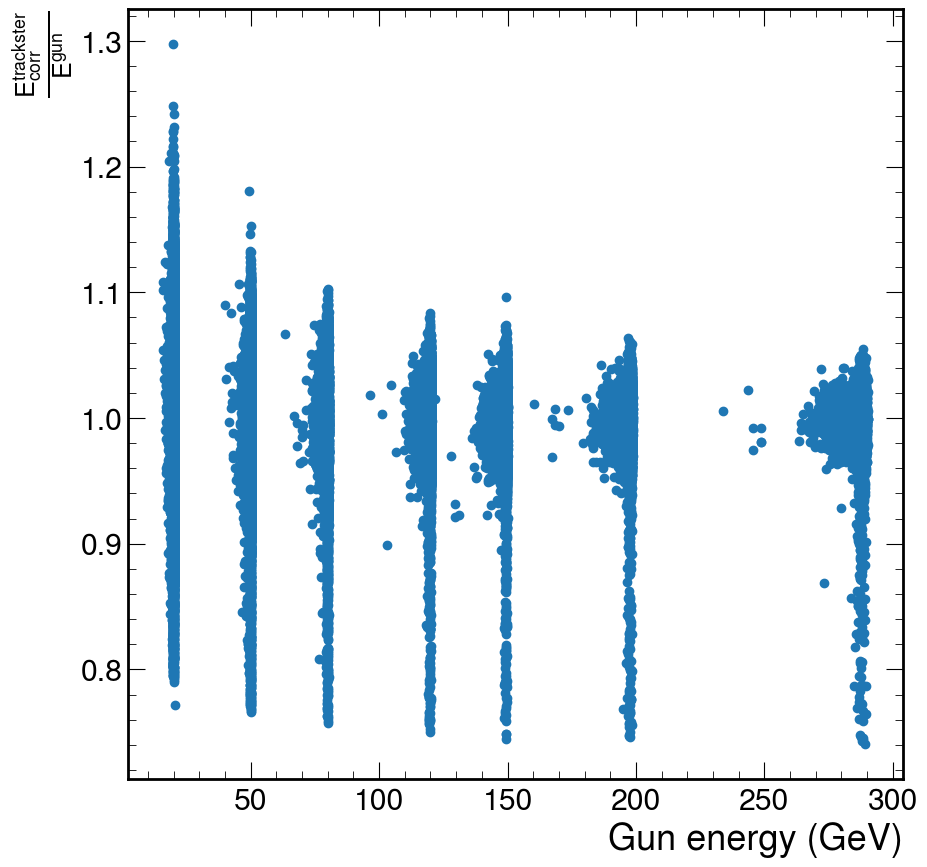

In [7]:
x = []
y = []
z=[]
for data in dataset:
    tracksterEnergy = torch.sum(data.x[:, 3]).item()
    x.append(data.trueBeamEnergy.item())
    z.append(data.beamEnergy.item())

    y.append(g(synchrotronBeamEnergiesMap[data.beamEnergy.item()], tracksterEnergy))
x, y, z = np.array(x), np.array(y), np.array(z)
plt.scatter(x, y/x)
plt.xlabel("Gun energy (GeV)")
plt.ylabel(r"$\frac{E^{trackster}_{corr}}{E^{gun}}$")

Text(0, 1, '$\\frac{E^{trackster}_{corr-mean-sigma}}{E^{gun}}$')

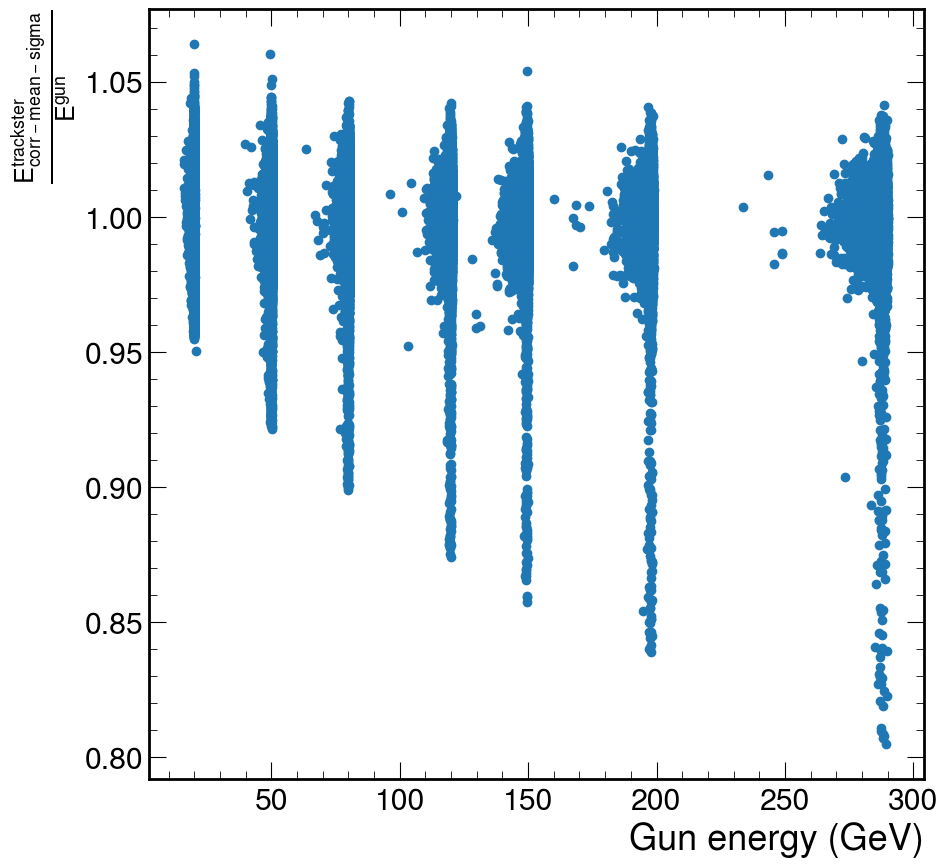

In [8]:
def identity(gun, ratio):
    return ratio
plt.scatter(x, [1e-2*h(gun, ratio-1)+1 for gun, ratio in zip(x, y/x)])
plt.xlabel("Gun energy (GeV)")
plt.ylabel(r"$\frac{E^{trackster}_{corr-mean-sigma}}{E^{gun}}$")

In [13]:
loss_terms_meancorr = defaultdict(list)
loss_terms_sigmacorr = defaultdict(list)
for gun, ratio_meancorr, beamEnergy in zip(x, y, z):
    loss_terms_meancorr[beamEnergy].append((1 - g(gun, tracksterEnergy))**2)
    loss_terms_sigmacorr[beamEnergy].append((1 - 1e-2*h(gun, ratio_meancorr-1)+1)**2)
loss_terms_meancorr =  dict(sorted(loss_terms_meancorr.items()))
loss_terms_sigmacorr =  dict(sorted(loss_terms_sigmacorr.items()))

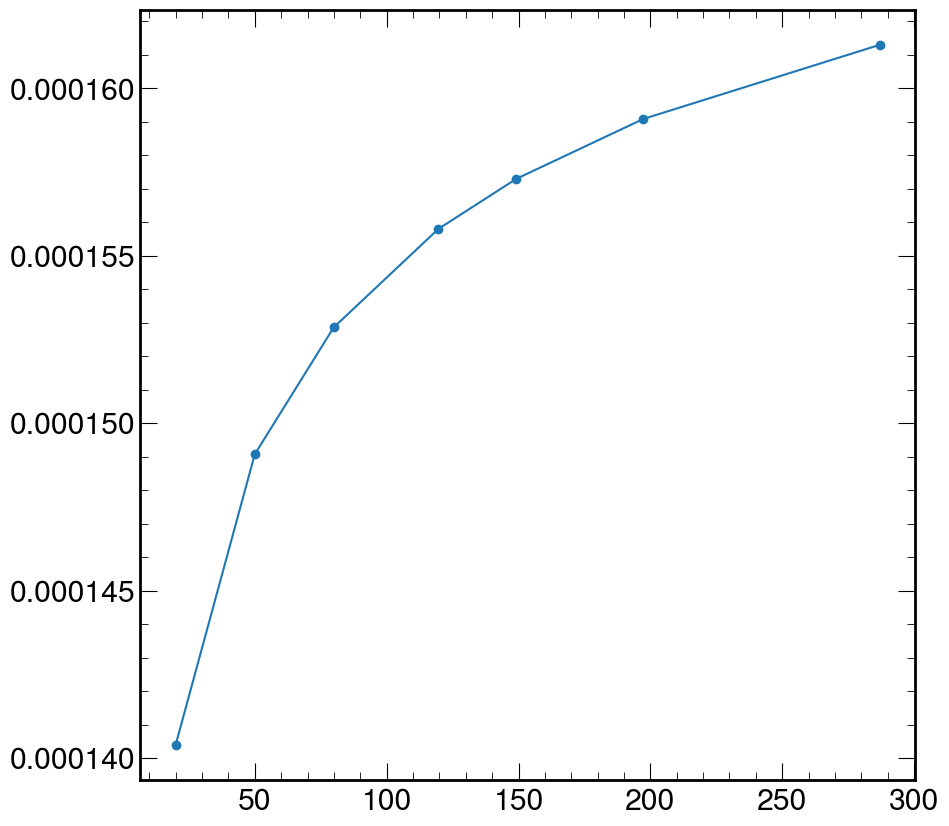

In [27]:
correction_factors = np.array([1/np.mean(vals) for vals in loss_terms_meancorr.values()])
plt.plot([synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in [20, 50, 80, 120, 150, 200, 300]], correction_factors, "o-")

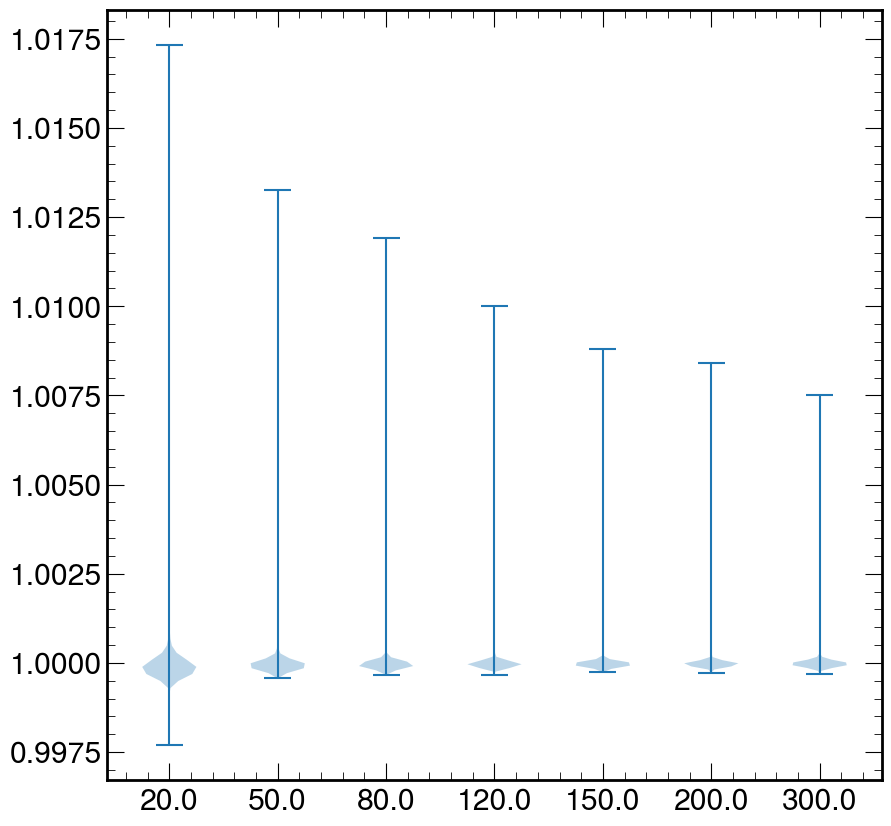

In [23]:
a = plt.violinplot([np.array(losses_list)*correction_factors[i] for i, losses_list in enumerate(loss_terms_meancorr.values())], vert=True)
a = plt.xticks(ticks=list(range(1, 1+len(loss_terms_meancorr))), labels=list(loss_terms_meancorr.keys()))

<BarContainer object of 7 artists>

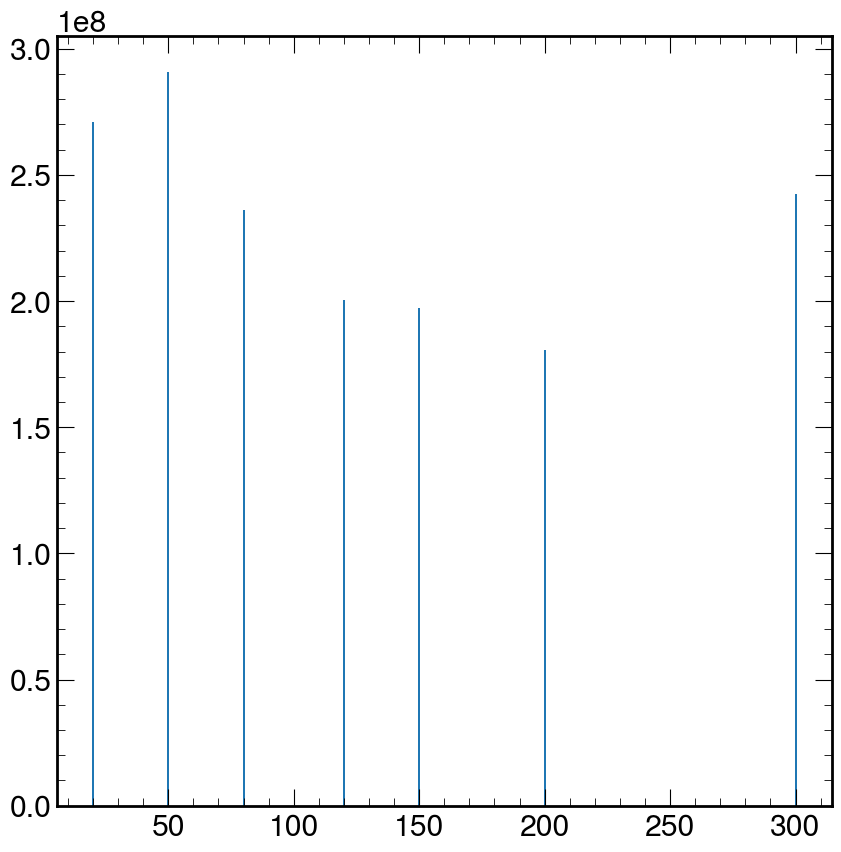

In [28]:
plt.bar(list(loss_terms_meancorr.keys()), [sum(losses) for losses in loss_terms_meancorr.values()])

In [ ]:
dataset.x#[:, 3]

tensor([[-0.9718,  1.6831,  1.0000,  0.2203],
        [-0.9550,  1.6735,  2.0000,  1.1610],
        [-0.9728,  1.6837,  3.0000,  2.5184],
        ...,
        [-1.4351,  0.8285, 22.0000,  0.0536],
        [ 0.0000,  0.3885, 23.0000,  0.0676],
        [-4.8588,  2.2771, 24.0000,  0.0653]])

LinregressResult(slope=0.00018493356357954195, intercept=0.9011979381615721, rvalue=0.47448102696616123, pvalue=0.0, stderr=6.896535507006271e-07, intercept_stderr=0.00010600592433272992)

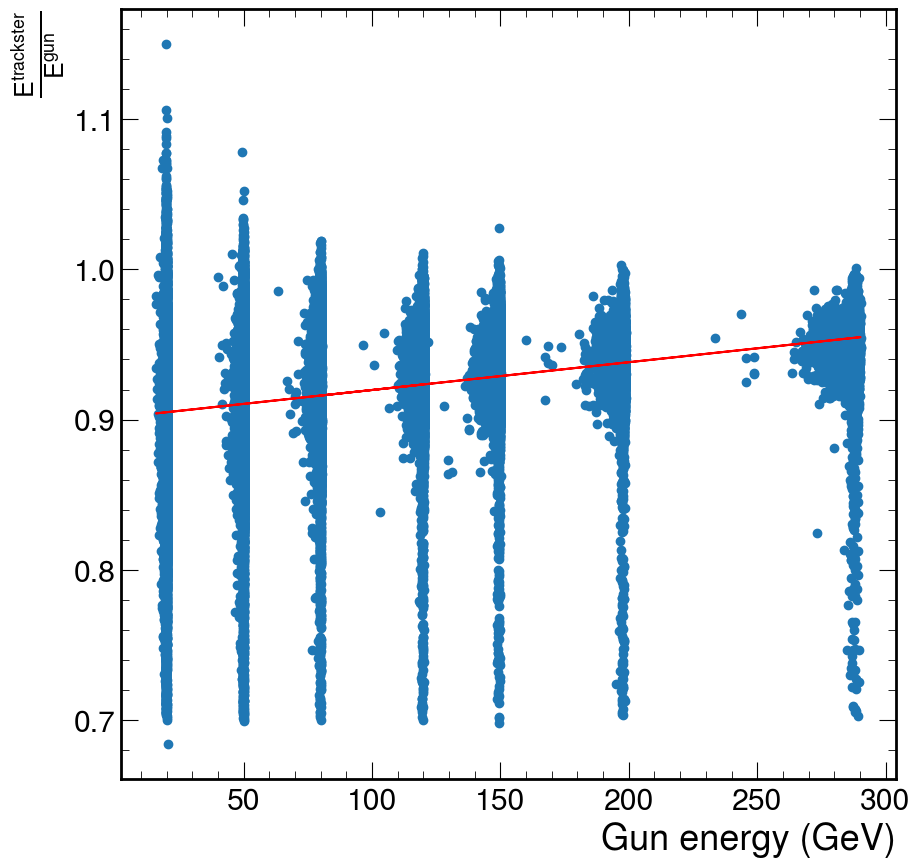

In [ ]:
x = []
y = []
z=[]
for data in dataset:
    tracksterEnergy = torch.sum(data.x[:, 3]).item()
    x.append(data.trueBeamEnergy.item())
    y.append(tracksterEnergy)
x, y, z = np.array(x), np.array(y), np.array(z)

res = scipy.stats.linregress(x, y/x)

plt.scatter(x, y/x)
plt.plot(x, res.intercept + res.slope*x, "r")

plt.xlabel("Gun energy (GeV)")
plt.ylabel(r"$\frac{E^{trackster}}{E^{gun}}$")
res

Text(0, 1, '$\\frac{E^{trackster}}{E^{gun}}$')

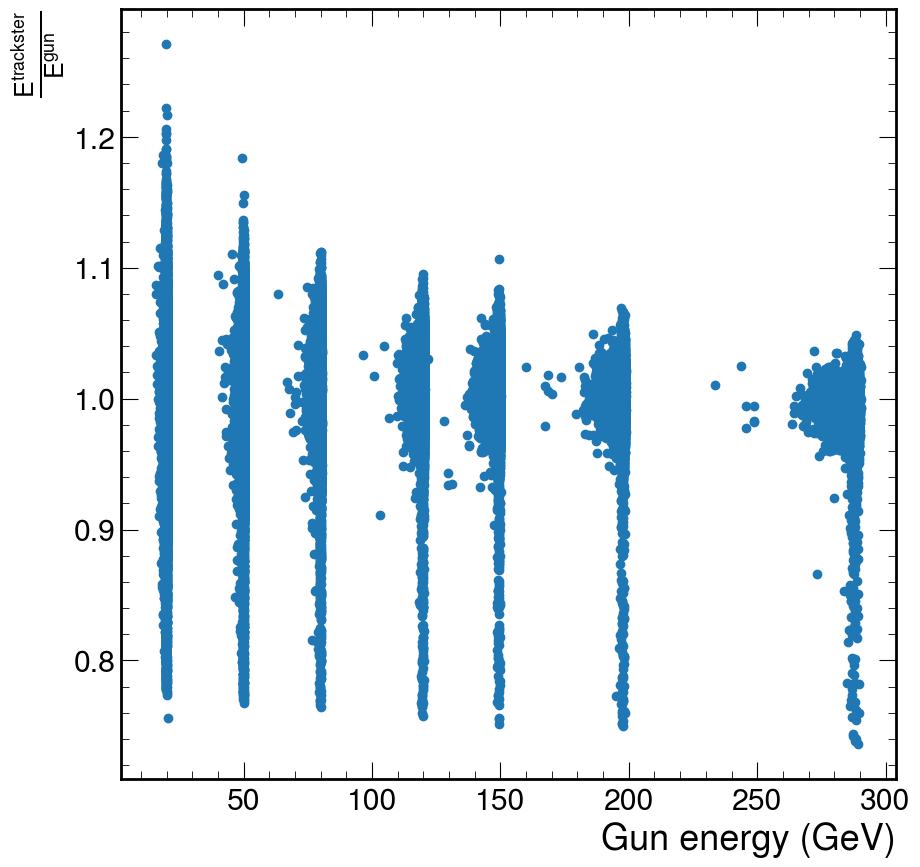

In [ ]:
plt.scatter(x, (y/x) / (res.intercept + res.slope*x))

plt.xlabel("Gun energy (GeV)")
plt.ylabel(r"$\frac{E^{trackster}}{E^{gun}}$")

In [ ]:
np.std((y/x) / (res.intercept + res.slope*x))

0.033266413199035054